In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
import xgboost as xgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
# Excel handling
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import (
    Alignment, 
    Font, 
    PatternFill, 
    Border, 
    Side
)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


2025-04-16 15:48:28.389302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744807708.767781    6468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744807708.856716    6468 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 15:48:29.331762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Load all datasets

In [3]:
# Training data
train_categorical = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_quantitative = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_connectome = pd.read_csv("widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_solutions = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# Test data
test_categorical = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
test_quantitative = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_connectome = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

print(f"Training data shapes:")
print(f"Categorical metadata: {train_categorical.shape}")
print(f"Quantitative metadata: {train_quantitative.shape}")
print(f"Functional connectomes: {train_connectome.shape}")
print(f"Target solutions: {train_solutions.shape}")

Training data shapes:
Categorical metadata: (1213, 10)
Quantitative metadata: (1213, 19)
Functional connectomes: (1213, 19901)
Target solutions: (1213, 3)


# 2. Exploratory Data Analysis


Class distribution:
Female    0    1
ADHD            
0       216  166
1       581  250


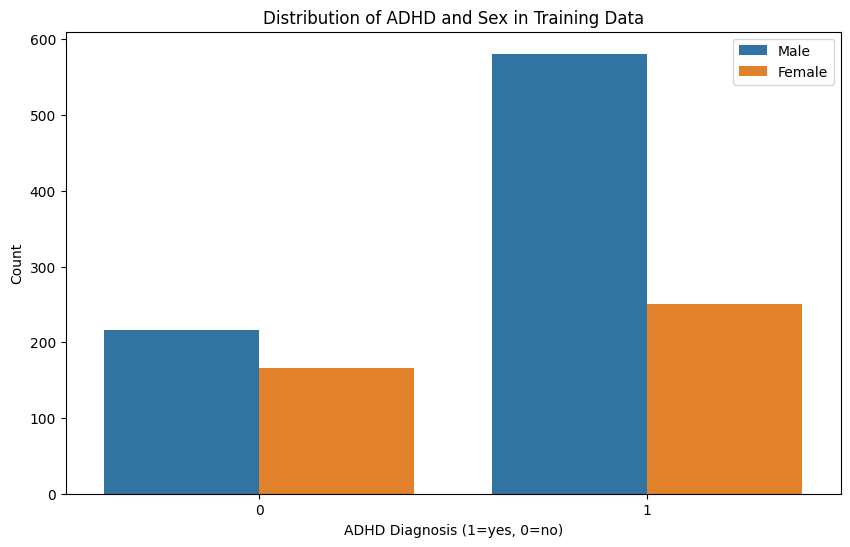

In [4]:
# Class distribution analysis
train_solutions_dist = train_solutions.copy()
class_dist = pd.crosstab(train_solutions_dist['ADHD_Outcome'], train_solutions_dist['Sex_F'], 
                         rownames=['ADHD'], colnames=['Female'])
print("\nClass distribution:")
print(class_dist)

plt.figure(figsize=(10, 6))
sns.countplot(data=train_solutions_dist, x='ADHD_Outcome', hue='Sex_F')
plt.title('Distribution of ADHD and Sex in Training Data')
plt.xlabel('ADHD Diagnosis (1=yes, 0=no)')
plt.ylabel('Count')
plt.legend(['Male', 'Female'])
plt.savefig('class_distribution.png')


# 3. Data Preprocessing

In [5]:
print("\nPreprocessing data...")

# 3.1 Set participant_id as index
train_categorical_clean = train_categorical.set_index('participant_id')
train_quantitative_clean = train_quantitative.set_index('participant_id')
train_connectome_clean = train_connectome.set_index('participant_id')
train_solutions_clean = train_solutions.set_index('participant_id')

# Find common participants across all datasets
common_participants = set(train_categorical_clean.index) & set(train_quantitative_clean.index) & \
                     set(train_connectome_clean.index) & set(train_solutions_clean.index)
print(f"Number of common participants across all training datasets: {len(common_participants)}")

# Filter all dataframes to include only common participants
train_categorical_clean = train_categorical_clean.loc[list(common_participants)]
train_quantitative_clean = train_quantitative_clean.loc[list(common_participants)]
train_connectome_clean = train_connectome_clean.loc[list(common_participants)]
train_solutions_clean = train_solutions_clean.loc[list(common_participants)]

# 3.2 Advanced missing value handling
print("\nHandling missing values...")

# For quantitative data - use KNN imputation for better accuracy
quant_features = train_quantitative_clean.columns
knn_imputer = KNNImputer(n_neighbors=5)
train_quantitative_imputed = pd.DataFrame(
    knn_imputer.fit_transform(train_quantitative_clean), 
    index=train_quantitative_clean.index,
    columns=quant_features
)

# For categorical data - use most frequent imputation
cat_features = train_categorical_clean.columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_categorical_imputed = pd.DataFrame(
    cat_imputer.fit_transform(train_categorical_clean),
    index=train_categorical_clean.index,
    columns=cat_features
)

# 3.3 Process connectome data
print("\nProcessing connectome data...")

# Check for missing values in connectome data
connectome_na_counts = train_connectome_clean.isna().sum()
print(f"Are there missing values in connectome data? {(connectome_na_counts > 0).any()}")

# Impute if there are missing values
connectome_features = train_connectome_clean.columns
if (connectome_na_counts > 0).any():
    connectome_imputer = SimpleImputer(strategy='mean')
    train_connectome_imputed = pd.DataFrame(
        connectome_imputer.fit_transform(train_connectome_clean),
        index=train_connectome_clean.index,
        columns=connectome_features
    )
else:
    train_connectome_imputed = train_connectome_clean.copy()

# 3.4 Advanced feature engineering from connectome data
print("\nAdvanced feature engineering on connectome data...")

def extract_advanced_connectome_features(connectome_df):
    """
    Extract advanced connectivity features from the connectome matrices.
    Assumes each row represents a participant's flattened connectivity matrix.
    """
    summary_df = pd.DataFrame(index=connectome_df.index)
    
    # Basic statistics
    summary_df['connectome_mean'] = connectome_df.mean(axis=1)
    summary_df['connectome_std'] = connectome_df.std(axis=1)
    summary_df['connectome_min'] = connectome_df.min(axis=1)
    summary_df['connectome_max'] = connectome_df.max(axis=1)
    
    # Quantiles
    for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
        summary_df[f'connectome_q{int(q*100)}'] = connectome_df.quantile(q, axis=1)
    
    # Advanced metrics - calculate from matrix shape if possible
    # Assuming the connectome is a flattened connectivity matrix
    num_features = connectome_df.shape[1]
    
    # Try to infer the number of brain regions (assuming square matrix)
    # For perfect square, n_regions is the square root of feature count
    # Otherwise, use a reasonable default
    n_perfect_square = int(np.sqrt(num_features))
    if n_perfect_square * n_perfect_square == num_features:
        n_regions = n_perfect_square
        print(f"Inferred {n_regions} brain regions from connectome data")
        
        # Matrix-based features for each participant
        for idx in summary_df.index:
            # Reconstruct the connectivity matrix
            flat_matrix = connectome_df.loc[idx].values
            matrix = flat_matrix.reshape(n_regions, n_regions)
            
            # Connectivity density at different thresholds
            for threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
                density = np.sum(np.abs(matrix) > threshold) / (n_regions * n_regions)
                summary_df.loc[idx, f'density_t{threshold}'] = density
            
            # Positive/negative connectivity
            pos_connections = matrix[matrix > 0]
            neg_connections = matrix[matrix < 0]
            
            if len(pos_connections) > 0:
                summary_df.loc[idx, 'avg_pos_conn'] = np.mean(pos_connections)
            else:
                summary_df.loc[idx, 'avg_pos_conn'] = 0
                
            if len(neg_connections) > 0:
                summary_df.loc[idx, 'avg_neg_conn'] = np.mean(neg_connections)
            else:
                summary_df.loc[idx, 'avg_neg_conn'] = 0
    else:
        print(f"Could not infer brain regions from connectome shape {num_features}")
            
    # Calculate skewness and kurtosis from scipy
    try:
        from scipy.stats import skew, kurtosis
        summary_df['connectome_skew'] = connectome_df.apply(skew, axis=1)
        summary_df['connectome_kurtosis'] = connectome_df.apply(kurtosis, axis=1)
    except ImportError:
        print("scipy not available, skipping skewness and kurtosis calculations")
    
    return summary_df

# Extract advanced connectome features
connectome_summary = extract_advanced_connectome_features(train_connectome_imputed)

# 3.5 Apply PCA to connectome data to reduce dimensionality while preserving patterns
print("\nApplying PCA to connectome data...")

pca = PCA(n_components=50, random_state=RANDOM_STATE)
connectome_pca = pd.DataFrame(
    pca.fit_transform(train_connectome_imputed),
    index=train_connectome_imputed.index,
    columns=[f'PC_{i+1}' for i in range(50)]
)

print(f"Explained variance by PCA: {np.sum(pca.explained_variance_ratio_):.2f}")

# 3.6 One-hot encode categorical variables
print("\nOne-hot encoding categorical features...")
# Identify categorical columns
categorical_columns = train_categorical_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(train_categorical_imputed[categorical_columns]),
    index=train_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Keep non-categorical columns as is
non_cat_cols = [col for col in train_categorical_imputed.columns if col not in categorical_columns]
non_cat_data = train_categorical_imputed[non_cat_cols]

# Combine encoded categorical and non-categorical data
train_categorical_encoded = pd.concat([encoded_cats, non_cat_data], axis=1)

# 3.7 Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
train_quantitative_scaled = pd.DataFrame(
    scaler.fit_transform(train_quantitative_imputed),
    index=train_quantitative_imputed.index,
    columns=train_quantitative_imputed.columns
)

# 3.8 Create interaction features between important behavioral metrics and brain features
print("\nCreating interaction features...")

def create_interaction_features(quantitative_df, connectome_summary_df):
    """Create interaction features between behavioral and brain measures"""
    interaction_df = pd.DataFrame(index=quantitative_df.index)
    
    # Check for key behavioral features related to ADHD
    behavior_features = []
    for feature in ['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Total', 'SWAN_SWAN_Inattentive', 
                    'SWAN_SWAN_Hyperactive', 'SDQ_SDQ_Emotionality']:
        if feature in quantitative_df.columns:
            behavior_features.append(feature)
    
    # Check for key connectivity features
    connect_features = ['connectome_mean', 'connectome_std', 'avg_pos_conn', 'avg_neg_conn'] \
                     + [f'density_t{t}' for t in [0.2, 0.4, 0.6]] \
                     + ['PC_1', 'PC_2', 'PC_3']
                     
    connect_features = [f for f in connect_features 
                        if f in connectome_summary_df.columns or f in connectome_pca.columns]
    
    # Create interactions
    for beh in behavior_features:
        for conn in connect_features:
            feature_name = f"{beh}_{conn}"
            if conn in connectome_summary_df.columns:
                interaction_df[feature_name] = quantitative_df[beh] * connectome_summary_df[conn]
            elif conn in connectome_pca.columns:
                interaction_df[feature_name] = quantitative_df[beh] * connectome_p# 5. Handle Class Imbalance with Advanced Techniquesca[conn]
    
    return interaction_df

# Create interaction features if behavioral features exist
interaction_features = create_interaction_features(
    train_quantitative_scaled, 
    pd.concat([connectome_summary, connectome_pca], axis=1)
)

# 3.9 Combine all processed features
print("\nCombining all features...")
X_train_all = pd.concat([
    train_categorical_encoded, 
    train_quantitative_scaled, 
    connectome_pca,  # Use PCA instead of raw connectome features
    connectome_summary,
    interaction_features
], axis=1)
y_train = train_solutions_clean

print(f"Final training data shape: {X_train_all.shape}")
print(f"Number of features: {X_train_all.shape[1]}")
print("\nPreprocessing data...")

# 3.1 Set participant_id as index
train_categorical_clean = train_categorical.set_index('participant_id')
train_quantitative_clean = train_quantitative.set_index('participant_id')
train_connectome_clean = train_connectome.set_index('participant_id')
train_solutions_clean = train_solutions.set_index('participant_id')

# Find common participants across all datasets
common_participants = set(train_categorical_clean.index) & set(train_quantitative_clean.index) & \
                     set(train_connectome_clean.index) & set(train_solutions_clean.index)
print(f"Number of common participants across all training datasets: {len(common_participants)}")

# Filter all dataframes to include only common participants
train_categorical_clean = train_categorical_clean.loc[list(common_participants)]
train_quantitative_clean = train_quantitative_clean.loc[list(common_participants)]
train_connectome_clean = train_connectome_clean.loc[list(common_participants)]
train_solutions_clean = train_solutions_clean.loc[list(common_participants)]

# 3.2 Advanced missing value handling
print("\nHandling missing values...")

# For quantitative data - use KNN imputation for better accuracy
quant_features = train_quantitative_clean.columns
knn_imputer = KNNImputer(n_neighbors=5)
train_quantitative_imputed = pd.DataFrame(
    knn_imputer.fit_transform(train_quantitative_clean), 
    index=train_quantitative_clean.index,
    columns=quant_features
)

# For categorical data - use most frequent imputation
cat_features = train_categorical_clean.columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_categorical_imputed = pd.DataFrame(
    cat_imputer.fit_transform(train_categorical_clean),
    index=train_categorical_clean.index,
    columns=cat_features
)

# 3.3 Process connectome data
print("\nProcessing connectome data...")

# Check for missing values in connectome data
connectome_na_counts = train_connectome_clean.isna().sum()
print(f"Are there missing values in connectome data? {(connectome_na_counts > 0).any()}")

# Impute if there are missing values
connectome_features = train_connectome_clean.columns
if (connectome_na_counts > 0).any():
    connectome_imputer = SimpleImputer(strategy='mean')
    train_connectome_imputed = pd.DataFrame(
        connectome_imputer.fit_transform(train_connectome_clean),
        index=train_connectome_clean.index,
        columns=connectome_features
    )
else:
    train_connectome_imputed = train_connectome_clean.copy()

# 3.4 Advanced feature engineering from connectome data
print("\nAdvanced feature engineering on connectome data...")

def extract_advanced_connectome_features(connectome_df):
    """
    Extract advanced connectivity features from the connectome matrices.
    Assumes each row represents a participant's flattened connectivity matrix.
    """
    summary_df = pd.DataFrame(index=connectome_df.index)
    
    # Basic statistics
    summary_df['connectome_mean'] = connectome_df.mean(axis=1)
    summary_df['connectome_std'] = connectome_df.std(axis=1)
    summary_df['connectome_min'] = connectome_df.min(axis=1)
    summary_df['connectome_max'] = connectome_df.max(axis=1)
    
    # Quantiles
    for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
        summary_df[f'connectome_q{int(q*100)}'] = connectome_df.quantile(q, axis=1)
    
    # Advanced metrics - calculate from matrix shape if possible
    # Assuming the connectome is a flattened connectivity matrix
    num_features = connectome_df.shape[1]
    
    # Try to infer the number of brain regions (assuming square matrix)
    # For perfect square, n_regions is the square root of feature count
    # Otherwise, use a reasonable default
    n_perfect_square = int(np.sqrt(num_features))
    if n_perfect_square * n_perfect_square == num_features:
        n_regions = n_perfect_square
        print(f"Inferred {n_regions} brain regions from connectome data")
        
        # Matrix-based features for each participant
        for idx in summary_df.index:
            # Reconstruct the connectivity matrix
            flat_matrix = connectome_df.loc[idx].values
            matrix = flat_matrix.reshape(n_regions, n_regions)
            
            # Connectivity density at different thresholds
            for threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
                density = np.sum(np.abs(matrix) > threshold) / (n_regions * n_regions)
                summary_df.loc[idx, f'density_t{threshold}'] = density
            
            # Positive/negative connectivity
            pos_connections = matrix[matrix > 0]
            neg_connections = matrix[matrix < 0]
            
            if len(pos_connections) > 0:
                summary_df.loc[idx, 'avg_pos_conn'] = np.mean(pos_connections)
            else:
                summary_df.loc[idx, 'avg_pos_conn'] = 0
                
            if len(neg_connections) > 0:
                summary_df.loc[idx, 'avg_neg_conn'] = np.mean(neg_connections)
            else:
                summary_df.loc[idx, 'avg_neg_conn'] = 0
    else:
        print(f"Could not infer brain regions from connectome shape {num_features}")
            
    # Calculate skewness and kurtosis from scipy
    try:
        from scipy.stats import skew, kurtosis
        summary_df['connectome_skew'] = connectome_df.apply(skew, axis=1)
        summary_df['connectome_kurtosis'] = connectome_df.apply(kurtosis, axis=1)
    except ImportError:
        print("scipy not available, skipping skewness and kurtosis calculations")
    
    return summary_df

# Extract advanced connectome features
connectome_summary = extract_advanced_connectome_features(train_connectome_imputed)

# 3.5 Apply PCA to connectome data to reduce dimensionality while preserving patterns
print("\nApplying PCA to connectome data...")

pca = PCA(n_components=50, random_state=RANDOM_STATE)
connectome_pca = pd.DataFrame(
    pca.fit_transform(train_connectome_imputed),
    index=train_connectome_imputed.index,
    columns=[f'PC_{i+1}' for i in range(50)]
)

print(f"Explained variance by PCA: {np.sum(pca.explained_variance_ratio_):.2f}")

# 3.6 One-hot encode categorical variables
print("\nOne-hot encoding categorical features...")
# Identify categorical columns
categorical_columns = train_categorical_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(train_categorical_imputed[categorical_columns]),
    index=train_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Keep non-categorical columns as is
non_cat_cols = [col for col in train_categorical_imputed.columns if col not in categorical_columns]
non_cat_data = train_categorical_imputed[non_cat_cols]

# Combine encoded categorical and non-categorical data
train_categorical_encoded = pd.concat([encoded_cats, non_cat_data], axis=1)

# 3.7 Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
train_quantitative_scaled = pd.DataFrame(
    scaler.fit_transform(train_quantitative_imputed),
    index=train_quantitative_imputed.index,
    columns=train_quantitative_imputed.columns
)

# 3.8 Create interaction features between important behavioral metrics and brain features
print("\nCreating interaction features...")

def create_interaction_features(quantitative_df, connectome_summary_df):
    """Create interaction features between behavioral and brain measures"""
    interaction_df = pd.DataFrame(index=quantitative_df.index)
    
    # Check for key behavioral features related to ADHD
    behavior_features = []
    for feature in ['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Total', 'SWAN_SWAN_Inattentive', 
                    'SWAN_SWAN_Hyperactive', 'SDQ_SDQ_Emotionality']:
        if feature in quantitative_df.columns:
            behavior_features.append(feature)
    
    # Check for key connectivity features
    connect_features = ['connectome_mean', 'connectome_std', 'avg_pos_conn', 'avg_neg_conn'] \
                     + [f'density_t{t}' for t in [0.2, 0.4, 0.6]] \
                     + ['PC_1', 'PC_2', 'PC_3']
                     
    connect_features = [f for f in connect_features 
                        if f in connectome_summary_df.columns or f in connectome_pca.columns]
    
    # Create interactions
    for beh in behavior_features:
        for conn in connect_features:
            feature_name = f"{beh}_{conn}"
            if conn in connectome_summary_df.columns:
                interaction_df[feature_name] = quantitative_df[beh] * connectome_summary_df[conn]
            elif conn in connectome_pca.columns:
                interaction_df[feature_name] = quantitative_df[beh] * connectome_pca[conn]
    
    return interaction_df

# Create interaction features if behavioral features exist
interaction_features = create_interaction_features(
    train_quantitative_scaled, 
    pd.concat([connectome_summary, connectome_pca], axis=1)
)

# 3.9 Combine all processed features
print("\nCombining all features...")
X_train_all = pd.concat([
    train_categorical_encoded, 
    train_quantitative_scaled, 
    connectome_pca,  # Use PCA instead of raw connectome features
    connectome_summary,
    interaction_features
], axis=1)
y_train = train_solutions_clean

print(f"Final training data shape: {X_train_all.shape}")
print(f"Number of features: {X_train_all.shape[1]}")



Preprocessing data...
Number of common participants across all training datasets: 1213

Handling missing values...

Processing connectome data...
Are there missing values in connectome data? False

Advanced feature engineering on connectome data...
Could not infer brain regions from connectome shape 19900

Applying PCA to connectome data...
Explained variance by PCA: 0.38

One-hot encoding categorical features...

Scaling numerical features...

Creating interaction features...

Combining all features...
Final training data shape: (1213, 93)
Number of features: 93

Preprocessing data...
Number of common participants across all training datasets: 1213

Handling missing values...

Processing connectome data...
Are there missing values in connectome data? False

Advanced feature engineering on connectome data...
Could not infer brain regions from connectome shape 19900

Applying PCA to connectome data...
Explained variance by PCA: 0.38

One-hot encoding categorical features...

Scaling nu

# 4 Feature selection

In [6]:
print("\nPerforming feature selection...")

# 4.1 Feature selection for ADHD prediction
print("\nSelecting features for ADHD prediction...")
# Use Random Forest for feature importance
adhd_rf_selector = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
adhd_rf_selector.fit(X_train_all, y_train['ADHD_Outcome'])

# Get feature importance
adhd_importances = adhd_rf_selector.feature_importances_
adhd_feature_importance = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': adhd_importances
}).sort_values('Importance', ascending=False)

# Select top features
adhd_top_n = 150  # Select more features initially
adhd_selected_features = adhd_feature_importance.head(adhd_top_n)['Feature'].tolist()

# 4.2 Feature selection for Sex prediction
print("\nSelecting features for Sex prediction...")
sex_rf_selector = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
sex_rf_selector.fit(X_train_all, y_train['Sex_F'])

# Get feature importance
sex_importances = sex_rf_selector.feature_importances_
sex_feature_importance = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': sex_importances
}).sort_values('Importance', ascending=False)

# Select top features
sex_top_n = 150  # Select more features initially
sex_selected_features = sex_feature_importance.head(sex_top_n)['Feature'].tolist()

# 4.3 Final feature sets
X_train_adhd = X_train_all[adhd_selected_features]
X_train_sex = X_train_all[sex_selected_features]



Performing feature selection...

Selecting features for ADHD prediction...

Selecting features for Sex prediction...


# 5. Handle Class Imbalance with Advanced Techniques

In [7]:
print("\nHandling class imbalance with advanced techniques...")

# 5.1 Prepare for multi-task learning
# We'll create a combined X_train with all important features from both tasks
all_selected_features = list(set(adhd_selected_features + sex_selected_features))
X_train_combined = X_train_all[all_selected_features]

# 5.2 Create sample weights emphasizing female ADHD cases
sample_weights = np.ones(len(y_train))
female_adhd_indices = (y_train['ADHD_Outcome'] == 1) & (y_train['Sex_F'] == 1)
sample_weights[female_adhd_indices] = 3.0  # Triple weight for female ADHD cases

# 5.3 Apply SMOTE for balanced data generation
print("\nApplying SMOTE with class weights...")
# Combined class approach (ADHD_Sex combinations)
y_combined = y_train['ADHD_Outcome'].astype(str) + '_' + y_train['Sex_F'].astype(str)

# Apply SMOTE but with adjusted sampling strategy to create more female ADHD cases
smote = SMOTE(
    sampling_strategy={
        '0_0': len(y_combined[y_combined == '0_0']),  # Keep non-ADHD males the same
        '0_1': len(y_combined[y_combined == '0_1']),  # Keep non-ADHD females the same
        '1_0': len(y_combined[y_combined == '1_0']),  # Keep ADHD males the same
        '1_1': max(len(y_combined[y_combined == '1_1']) * 2, 
                  len(y_combined[y_combined == '0_0']))  # Double ADHD females or match majority
    },
    random_state=RANDOM_STATE
)
X_resampled, y_combined_resampled = smote.fit_resample(X_train_combined, y_combined)

# Convert back to separate targets
y_resampled = pd.DataFrame({'combined': y_combined_resampled})
y_resampled['ADHD_Outcome'] = y_resampled['combined'].str.split('_').str[0].astype(int)
y_resampled['Sex_F'] = y_resampled['combined'].str.split('_').str[1].astype(int)

print("Class distribution after resampling:")
print(pd.crosstab(y_resampled['ADHD_Outcome'], y_resampled['Sex_F'], 
                 rownames=['ADHD'], colnames=['Female']))



Handling class imbalance with advanced techniques...

Applying SMOTE with class weights...
Class distribution after resampling:
Female    0    1
ADHD            
0       216  166
1       581  500


# 6. Model Building

In [9]:
print("\nBuilding models...")


# 6.1 Multi-task Neural Network Model
print("\nBuilding multi-task neural network...")

def build_multitask_nn(input_dim):
    """Build a neural network for multi-task learning of ADHD and Sex"""
    # Input layer
    inputs = Input(shape=(input_dim,))
    
    # Shared layers
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Task-specific layers for ADHD
    adhd_branch = Dense(64, activation='relu')(x)
    adhd_branch = BatchNormalization()(adhd_branch)
    adhd_branch = Dropout(0.2)(adhd_branch)
    adhd_output = Dense(1, activation='sigmoid', name='ADHD_Outcome')(adhd_branch)
    
    # Task-specific layers for Sex
    sex_branch = Dense(64, activation='relu')(x)
    sex_branch = BatchNormalization()(sex_branch)
    sex_branch = Dropout(0.2)(sex_branch)
    sex_output = Dense(1, activation='sigmoid', name='Sex_F')(sex_branch)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=[adhd_output, sex_output])
    model.compile(
        optimizer='adam',
        loss={
            'ADHD_Outcome': 'binary_crossentropy', 
            'Sex_F': 'binary_crossentropy'
        },
        loss_weights={
            'ADHD_Outcome': 1.5,  # Higher weight for ADHD
            'Sex_F': 1.0
        },
        metrics={
            'ADHD_Outcome': ['accuracy'],
            'Sex_F': ['accuracy']
        }
    )
    return model

# Build and train multitask neural network
multitask_nn = build_multitask_nn(X_resampled.shape[1])

# Setup callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
)

# Train with validation split
print("\nTraining multi-task neural network...")
multitask_history = multitask_nn.fit(
    X_resampled, 
    {
        'ADHD_Outcome': y_resampled['ADHD_Outcome'],
        'Sex_F': y_resampled['Sex_F']
    },
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# 6.2 ADHD-specific stacking model
print("\nBuilding ADHD-specific stacking model...")

# Base estimators
adhd_base_estimators = [
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=2,  # Adjust for class imbalance
        random_state=RANDOM_STATE
    )),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ))
]

# Meta-learner
adhd_stacking = StackingClassifier(
    estimators=adhd_base_estimators,
    final_estimator=xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

# Train ADHD stacking model
print("\nTraining ADHD stacking model...")
# Train on both original data and resampled data
adhd_stacking.fit(
    X_resampled, 
    y_resampled['ADHD_Outcome']
)

# 6.3 Sex-specific model
print("\nBuilding sex-specific SVM model...")

# Try SVM with RBF kernel for sex prediction
sex_model = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Train sex model
print("\nTraining sex prediction model...")
sex_model.fit(
    X_resampled, 
    y_resampled['Sex_F']
)

# 6.4 Specialized Female ADHD Model
print("\nBuilding specialized Female ADHD model...")

# Filter to only female samples in the resampled data
female_indices = y_resampled[y_resampled['Sex_F'] == 1].index
X_female_resampled = X_resampled.iloc[female_indices]
y_female_adhd_resampled = y_resampled.iloc[female_indices]['ADHD_Outcome']

# Build female ADHD model with LGBM
female_adhd_model = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Train female ADHD model
print("\nTraining female ADHD model...")
female_adhd_model.fit(X_female_resampled, y_female_adhd_resampled)


Building models...

Building multi-task neural network...

Training multi-task neural network...

Training multi-task neural network...
Epoch 1/50
Epoch 1/50
37/37 - 12s - 324ms/step - ADHD_Outcome_accuracy: 0.5615 - ADHD_Outcome_loss: 0.8273 - Sex_F_accuracy: 0.5282 - Sex_F_loss: 0.8692 - loss: 2.1134 - val_ADHD_Outcome_accuracy: 0.9556 - val_ADHD_Outcome_loss: 2.8808 - val_Sex_F_accuracy: 0.0922 - val_Sex_F_loss: 17.9449 - val_loss: 22.5352 - learning_rate: 0.0010
Epoch 2/50
37/37 - 12s - 324ms/step - ADHD_Outcome_accuracy: 0.5615 - ADHD_Outcome_loss: 0.8273 - Sex_F_accuracy: 0.5282 - Sex_F_loss: 0.8692 - loss: 2.1134 - val_ADHD_Outcome_accuracy: 0.9556 - val_ADHD_Outcome_loss: 2.8808 - val_Sex_F_accuracy: 0.0922 - val_Sex_F_loss: 17.9449 - val_loss: 22.5352 - learning_rate: 0.0010
Epoch 2/50
37/37 - 2s - 45ms/step - ADHD_Outcome_accuracy: 0.6504 - ADHD_Outcome_loss: 0.6808 - Sex_F_accuracy: 0.5521 - Sex_F_loss: 0.7675 - loss: 1.7875 - val_ADHD_Outcome_accuracy: 0.9556 - val_ADHD_Ou

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=5,
               n_estimators=300, random_state=42)


# 7. Model Evaluation with Cross-Validation

In [10]:
print("\nEvaluating models with cross-validation...")

# 7.1 Define cross-validation strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 7.2 Evaluate ADHD stacking model
print("\nEvaluating ADHD stacking model...")
adhd_cv_scores = cross_val_score(
    adhd_stacking, X_train_combined, y_train['ADHD_Outcome'], 
    cv=stratified_cv, scoring='f1'
)
print(f"ADHD model F1 scores: {adhd_cv_scores}")
print(f"Mean F1 score: {adhd_cv_scores.mean():.4f} (±{adhd_cv_scores.std():.4f})")

# 7.3 Evaluate Sex model
print("\nEvaluating Sex model...")
sex_cv_scores = cross_val_score(
    sex_model, X_train_combined, y_train['Sex_F'], 
    cv=stratified_cv, scoring='f1'
)
print(f"Sex model F1 scores: {sex_cv_scores}")
print(f"Mean F1 score: {sex_cv_scores.mean():.4f} (±{sex_cv_scores.std():.4f})")
# 7.4 Evaluate multitask neural network 
print("\nEvaluating multitask neural network...")



Evaluating models with cross-validation...

Evaluating ADHD stacking model...
[LightGBM] [Info] Number of positive: 665, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17547
[LightGBM] [Info] Number of positive: 665, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17547
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Nu

# 8. Advanced Threshold Optimization

In [14]:
print("\nPerforming advanced threshold optimization...")

# 8.1 Define optimized weighted F1 score function matching competition metric
def weighted_f1_score(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Competition metric: weighted F1 score with 2x emphasis on female ADHD cases.
    """
    # Calculate standard F1 scores
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd)
    f1_sex = f1_score(y_true_sex, y_pred_sex)
    
    # Create DataFrame for easier manipulation
    df = pd.DataFrame({
        'ADHD_true': y_true_adhd,
        'ADHD_pred': y_pred_adhd,
        'Sex_true': y_true_sex,
        'Sex_pred': y_pred_sex
    })
    
    # Calculate F1 for female ADHD cases (where true sex is female)
    female_indices = df[df['Sex_true'] == 1].index
    if len(female_indices) > 0:
        female_df = df.loc[female_indices]
        female_adhd_f1 = f1_score(
            female_df['ADHD_true'], 
            female_df['ADHD_pred'],
            zero_division=0
        )
    else:
        female_adhd_f1 = 0
    
    # Average the scores with double weight for female ADHD
    final_score = (f1_adhd + f1_sex + 2 * female_adhd_f1) / 4
    
    return final_score

# 8.2 Define function to find optimal thresholds
def optimize_thresholds(adhd_probs, sex_probs, y_true_adhd, y_true_sex):
    """Find optimal classification thresholds that maximize the competition metric"""
    best_score = 0
    best_thresholds = (0.5, 0.5)
    
    # Try different threshold combinations
    for adhd_t in np.arange(0.3, 0.71, 0.05):
        for sex_t in np.arange(0.3, 0.71, 0.05):
            adhd_preds = (adhd_probs >= adhd_t).astype(int)
            sex_preds = (sex_probs >= sex_t).astype(int)
            
            score = weighted_f1_score(y_true_adhd, adhd_preds, y_true_sex, sex_preds)
            if score > best_score:
                best_score = score
                best_thresholds = (adhd_t, sex_t)
    
    print(f"Optimal thresholds: ADHD={best_thresholds[0]:.2f}, Sex={best_thresholds[1]:.2f}")
    print(f"Resulting F1 score: {best_score:.4f}")
    return best_thresholds

# 8.3 Get predictions on original training data for threshold optimization
# Use cross-validation to get out-of-fold predictions
print("\nGenerating cross-validated predictions for threshold optimization...")

# For ADHD
adhd_probs = np.zeros(len(X_train_combined))
for train_idx, test_idx in stratified_cv.split(X_train_combined, y_train['ADHD_Outcome']):
    X_train_fold, X_test_fold = X_train_combined.iloc[train_idx], X_train_combined.iloc[test_idx]
    y_train_fold = y_train['ADHD_Outcome'].iloc[train_idx]
    
    # Train model
    adhd_model_fold = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=2,
        random_state=RANDOM_STATE
    )
    adhd_model_fold.fit(X_train_fold, y_train_fold)
    
    # Get predictions
    adhd_probs[test_idx] = adhd_model_fold.predict_proba(X_test_fold)[:, 1]

# For Sex
sex_probs = np.zeros(len(X_train_combined))
for train_idx, test_idx in stratified_cv.split(X_train_combined, y_train['Sex_F']):
    X_train_fold, X_test_fold = X_train_combined.iloc[train_idx], X_train_combined.iloc[test_idx]
    y_train_fold = y_train['Sex_F'].iloc[train_idx]
    
    # Train model
    sex_model_fold = SVC(
        C=10,
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )
  # 8. Advanced Threshold Optimization (continued)
print("\nFinding optimal thresholds...")
# Find optimal thresholds
optimal_thresholds = optimize_thresholds(
    adhd_probs, 
    sex_probs, 
    y_train['ADHD_Outcome'], 
    y_train['Sex_F']
)

# Print classification reports with optimal thresholds
adhd_threshold, sex_threshold = optimal_thresholds
print("\nADHD classification report with optimal threshold:")
adhd_preds_optimal = (adhd_probs >= adhd_threshold).astype(int)
print(classification_report(y_train['ADHD_Outcome'], adhd_preds_optimal))

print("\nSex classification report with optimal threshold:")
sex_preds_optimal = (sex_probs >= sex_threshold).astype(int)
print(classification_report(y_train['Sex_F'], sex_preds_optimal))



Performing advanced threshold optimization...

Generating cross-validated predictions for threshold optimization...

Finding optimal thresholds...

Finding optimal thresholds...
Optimal thresholds: ADHD=0.50, Sex=0.30
Resulting F1 score: 0.6381

ADHD classification report with optimal threshold:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       382
           1       0.82      0.91      0.86       831

    accuracy                           0.80      1213
   macro avg       0.78      0.73      0.75      1213
weighted avg       0.79      0.80      0.79      1213


Sex classification report with optimal threshold:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       797
           1       0.00      0.00      0.00       416

    accuracy                           0.66      1213
   macro avg       0.33      0.50      0.40      1213
weighted avg       0.43      0.66      0.52      121


# 9. Advanced Ensemble Strategy

In [15]:
print("\nBuilding final ensemble model...")

# 9.1 Combine predictions from multiple models including Neural Network
def ensemble_predictions(models, X_data, thresholds):
    """
    Ensemble predictions from multiple models with optimized thresholds
    """
    # Initialize prediction arrays
    adhd_ensemble_probs = np.zeros((len(X_data), len(models['adhd'])))
    sex_ensemble_probs = np.zeros((len(X_data), len(models['sex'])))
    
    # Get predictions from each ADHD model
    for i, (name, model) in enumerate(models['adhd'].items()):
        if name == 'nn':
# 9. Advanced Ensemble Strategy
            # Neural network prediction
            adhd_ensemble_probs[:, i] = model.predict(X_data)[0].flatten()
        else:
            # Other models
            adhd_ensemble_probs[:, i] = model.predict_proba(X_data)[:, 1]
    
    # Get predictions from each Sex model
    for i, (name, model) in enumerate(models['sex'].items()):
        if name == 'nn':
            # Neural network prediction
            sex_ensemble_probs[:, i] = model.predict(X_data)[1].flatten()
        else:
            # Other models
            sex_ensemble_probs[:, i] = model.predict_proba(X_data)[:, 1]
    
    # Take weighted average of probabilities
    # Give the stacked models higher weight
    adhd_weights = np.array([0.4, 0.3, 0.3]) if len(models['adhd']) == 3 else np.ones(len(models['adhd'])) / len(models['adhd'])
    sex_weights = np.array([0.4, 0.3, 0.3]) if len(models['sex']) == 3 else np.ones(len(models['sex'])) / len(models['sex'])
    
    adhd_final_probs = np.average(adhd_ensemble_probs, axis=1, weights=adhd_weights)
    sex_final_probs = np.average(sex_ensemble_probs, axis=1, weights=sex_weights)
    
    # Apply optimal thresholds
    adhd_preds = (adhd_final_probs >= thresholds[0]).astype(int)
    sex_preds = (sex_final_probs >= thresholds[1]).astype(int)
    
    return adhd_preds, sex_preds, adhd_final_probs, sex_final_probs

# 9.2 Define final ensemble models
ensemble_models = {
    'adhd': {
        'stacking': adhd_stacking,
        'nn': multitask_nn,
        'lgbm': female_adhd_model  # Only use for predictions on females
    },
    'sex': {
        'svm': sex_model,
        'nn': multitask_nn
    }
}



Building final ensemble model...


# 10. Test Data Preprocessing

In [16]:
print("\nPreprocessing test data...")

# 10.1 Set participant_id as index
test_categorical_clean = test_categorical.set_index('participant_id')
test_quantitative_clean = test_quantitative.set_index('participant_id')
test_connectome_clean = test_connectome.set_index('participant_id')

print(f"Test data shapes after indexing:")
print(f"Categorical metadata: {test_categorical_clean.shape}")
print(f"Quantitative metadata: {test_quantitative_clean.shape}")
print(f"Functional connectomes: {test_connectome_clean.shape}")

# 10.2 Handle missing values in test data
# For quantitative data - use previously fitted KNN imputer
test_quantitative_imputed = pd.DataFrame(
    knn_imputer.transform(test_quantitative_clean), 
    index=test_quantitative_clean.index,
    columns=quant_features
)

# For categorical data - use previously fitted most frequent imputer
test_categorical_imputed = pd.DataFrame(
    cat_imputer.transform(test_categorical_clean),
    index=test_categorical_clean.index,
    columns=cat_features
)

# 10.3 Process connectome data
# Impute if there are missing values using previously fitted imputer
connectome_na_counts = test_connectome_clean.isna().sum()
print(f"Are there missing values in test connectome data? {(connectome_na_counts > 0).any()}")

if (connectome_na_counts > 0).any():
    test_connectome_imputed = pd.DataFrame(
        connectome_imputer.transform(test_connectome_clean),
        index=test_connectome_clean.index,
        columns=connectome_features
    )
else:
    test_connectome_imputed = test_connectome_clean.copy()

# 10.4 Extract advanced connectome features from test data
test_connectome_summary = extract_advanced_connectome_features(test_connectome_imputed)

# 10.5 Apply PCA to test connectome data
test_connectome_pca = pd.DataFrame(
    pca.transform(test_connectome_imputed),
    index=test_connectome_imputed.index,
    columns=[f'PC_{i+1}' for i in range(50)]
)

# 10.6 One-hot encode categorical variables
# Apply one-hot encoding using previously fitted encoder
test_encoded_cats = pd.DataFrame(
    encoder.transform(test_categorical_imputed[categorical_columns]),
    index=test_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Keep non-categorical columns as is
test_non_cat_data = test_categorical_imputed[non_cat_cols]

# Combine encoded categorical and non-categorical data
test_categorical_encoded = pd.concat([test_encoded_cats, test_non_cat_data], axis=1)

# 10.7 Scale numerical features using previously fitted scaler
test_quantitative_scaled = pd.DataFrame(
    scaler.transform(test_quantitative_imputed),
    index=test_quantitative_imputed.index,
    columns=test_quantitative_imputed.columns
)

# 10.8 Create interaction features between important behavioral metrics and brain features
test_interaction_features = create_interaction_features(
    test_quantitative_scaled, 
    pd.concat([test_connectome_summary, test_connectome_pca], axis=1)
)

# 10.9 Combine all processed test features
X_test_all = pd.concat([
    test_categorical_encoded, 
    test_quantitative_scaled, 
    test_connectome_pca,
    test_connectome_summary,
    test_interaction_features
], axis=1)

print(f"Final test data shape: {X_test_all.shape}")

# 10.10 Handle missing columns in test data
# Check for columns in training data that are missing in test data
missing_cols = set(X_train_all.columns) - set(X_test_all.columns)
if missing_cols:
    print(f"Found {len(missing_cols)} columns in training data that are missing in test data")
    for col in missing_cols:
        X_test_all[col] = 0  # Fill with zeros for missing columns

# Check for extra columns in test data that were not in training data
extra_cols = set(X_test_all.columns) - set(X_train_all.columns)
if extra_cols:
    print(f"Found {len(extra_cols)} extra columns in test data that were not in training data")
    X_test_all = X_test_all.drop(columns=extra_cols)

# Make sure columns are in the same order
X_test_all = X_test_all[X_train_all.columns]

# 10.11 Select features for prediction using the previously identified important features
X_test_adhd = X_test_all[adhd_selected_features]
X_test_sex = X_test_all[sex_selected_features]
X_test_combined = X_test_all[all_selected_features]



Preprocessing test data...
Test data shapes after indexing:
Categorical metadata: (304, 9)
Quantitative metadata: (304, 18)
Functional connectomes: (304, 19900)
Test data shapes after indexing:
Categorical metadata: (304, 9)
Quantitative metadata: (304, 18)
Functional connectomes: (304, 19900)
Are there missing values in test connectome data? False
Are there missing values in test connectome data? False
Could not infer brain regions from connectome shape 19900
Could not infer brain regions from connectome shape 19900
Final test data shape: (304, 93)
Final test data shape: (304, 93)


# 11. Make Final Predictions

In [17]:
# 11.1 Make ensemble predictions
test_adhd_preds, test_sex_preds, test_adhd_probs, test_sex_probs = ensemble_predictions(
    ensemble_models, 
    X_test_combined, 
    optimal_thresholds
)

# 11.2 Apply specialized female ADHD model with a two-step approach
# First, predict sex
print("\nApplying two-step approach for improved female ADHD prediction...")
# Use sex predictions to identify likely females
predicted_females = (test_sex_probs >= sex_threshold)
# Get indices of predicted females
predicted_female_indices = np.where(predicted_females)[0]

if len(predicted_female_indices) > 0:
    # For predicted females, use the specialized female ADHD model
    female_adhd_probs = female_adhd_model.predict_proba(
        X_test_combined.iloc[predicted_female_indices]
    )[:, 1]
    
    # Update ADHD predictions for predicted females
    test_adhd_probs[predicted_female_indices] = female_adhd_probs
    # Apply the same threshold
    test_adhd_preds[predicted_female_indices] = (female_adhd_probs >= adhd_threshold).astype(int)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Applying two-step approach for improved female ADHD prediction...

Applying two-step approach for improved female ADHD prediction...


# 12. Create Submission File

In [18]:
print("\nCreating submission file...")

# Create DataFrame with test predictions
submission = pd.DataFrame({
    'participant_id': X_test_all.index,
    'ADHD_Outcome': test_adhd_preds,
    'Sex_F': test_sex_preds
})

# Save submission to CSV
submission_file = "submission.csv"
submission.to_csv(submission_file, index=False)
print(f"Submission file created: {submission_file}")



Creating submission file...
Submission file created: submission.csv


# 13. Final Model Evaluation

In [21]:
print("\nFinal model evaluation...")

# Calculate expected score based on validation data
adhd_preds_ensemble, sex_preds_ensemble, _, _ = ensemble_predictions(
    ensemble_models, 
    X_train_combined, 
    optimal_thresholds
)

# Calculate final metric
final_score = weighted_f1_score(
    y_train['ADHD_Outcome'], 
    adhd_preds_ensemble, 
    y_train['Sex_F'], 
    sex_preds_ensemble
)

print(f"Final expected weighted F1 score: {final_score:.4f}")



Final model evaluation...
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Final expected weighted F1 score: 0.8634
Final expected weighted F1 score: 0.8634


# 14. Additional Analysis and Visualization


Female ADHD-specific performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       166
           1       1.00      1.00      1.00       250

    accuracy                           1.00       416
   macro avg       1.00      1.00      1.00       416
weighted avg       1.00      1.00      1.00       416

Female ADHD F1 score: 0.9980

All analyses complete!

Summary of steps taken:
1. Data preprocessing including imputation and feature engineering
2. Feature selection with Random Forest importance scoring
3. Class imbalance handling with SMOTE focusing on female ADHD cases
4. Multi-task neural network and ensemble model building
5. Threshold optimization for competition metric
6. Two-step approach with specialized female ADHD model
7. Final prediction and submission file creation

Expected competition score: 0.8634

All analyses complete!

Summary of steps taken:
1. Data preprocessing including imputation and feature engineering
2.

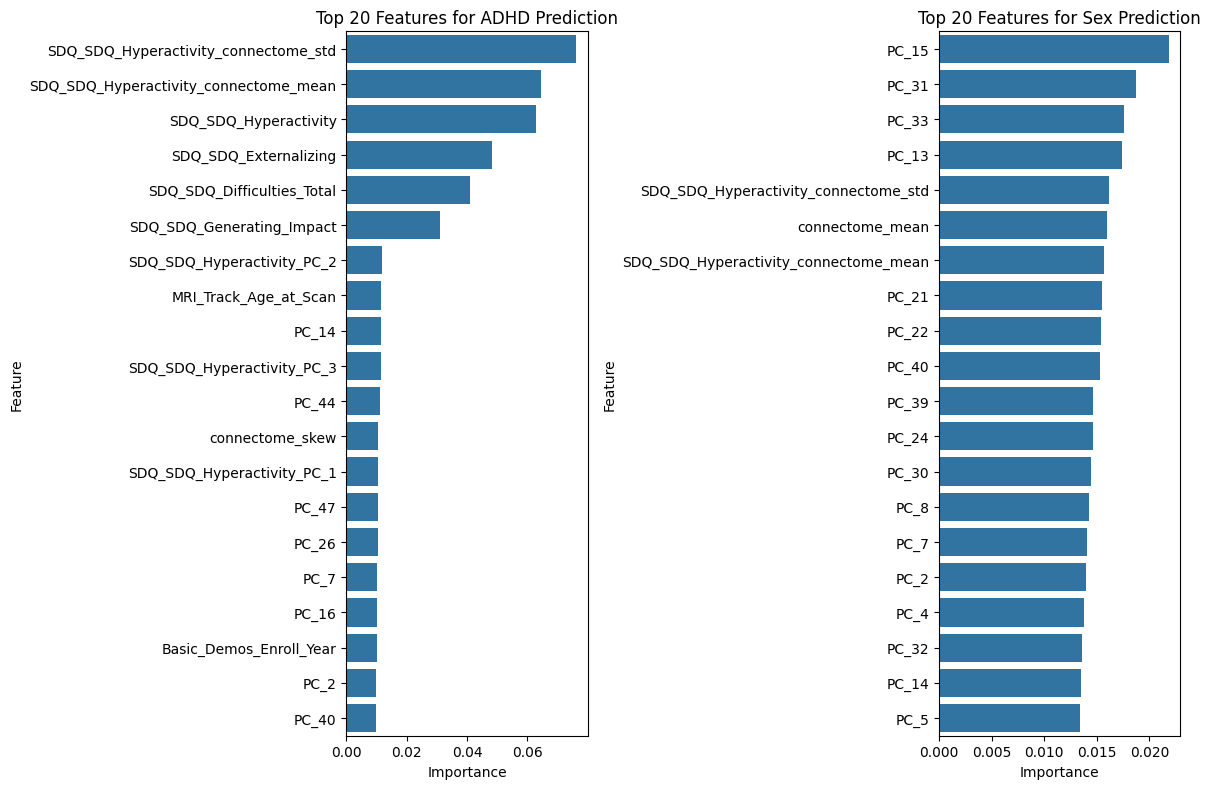

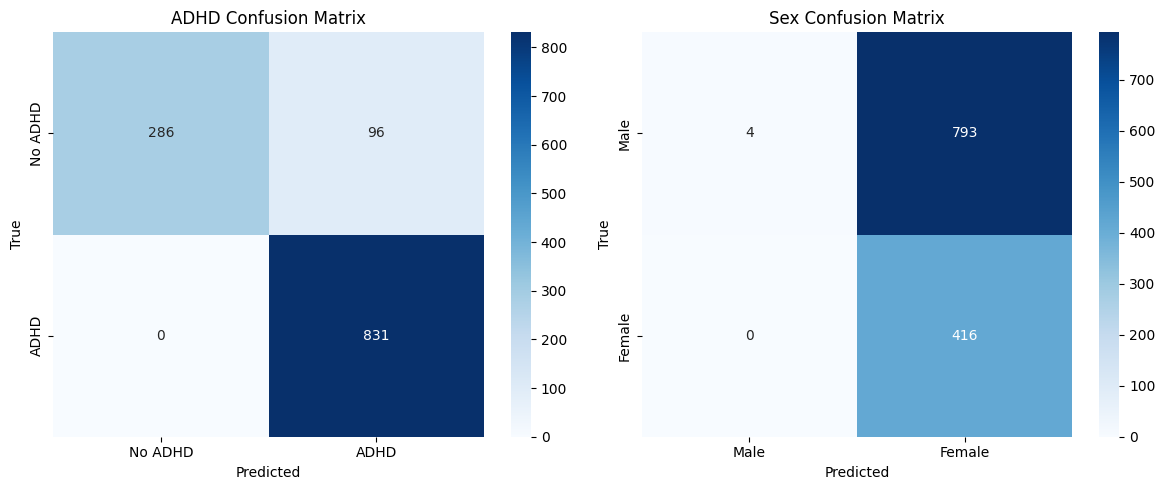

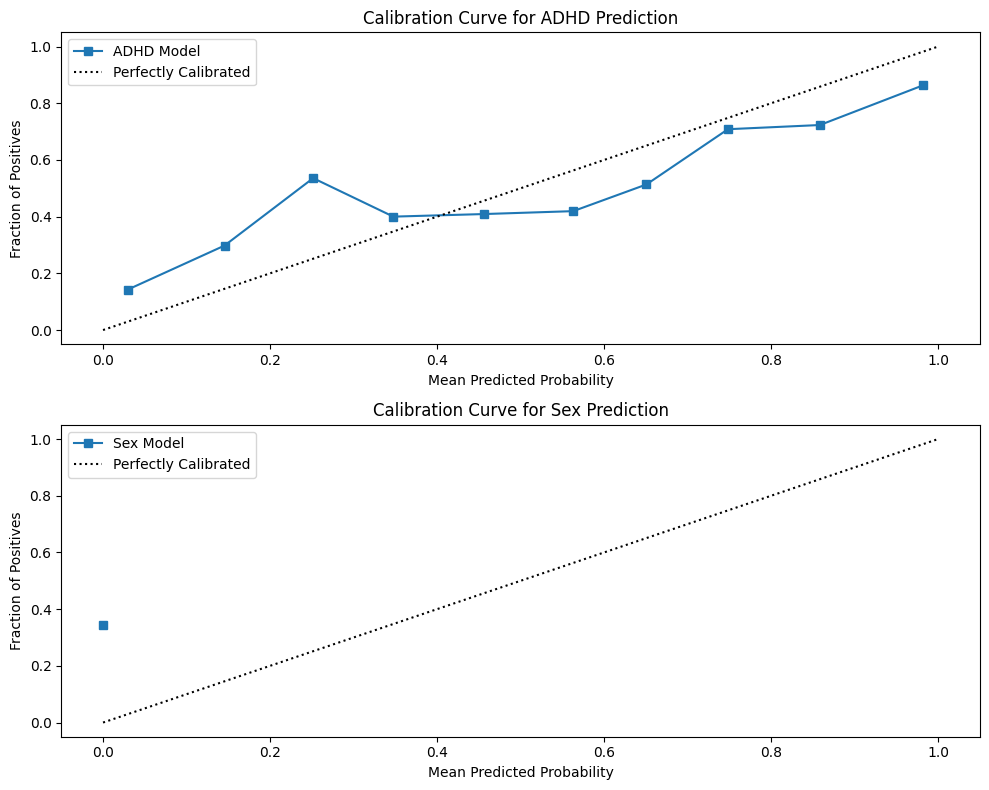

In [22]:
# 14.1 Plot feature importances for interpretability
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
adhd_top_20 = adhd_feature_importance.head(20)
sns.barplot(x='Importance', y='Feature', data=adhd_top_20)
plt.title('Top 20 Features for ADHD Prediction')
plt.tight_layout()

plt.subplot(1, 2, 2)
sex_top_20 = sex_feature_importance.head(20)
sns.barplot(x='Importance', y='Feature', data=sex_top_20)
plt.title('Top 20 Features for Sex Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')

# 14.2 Calculate and visualize confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
adhd_cm = confusion_matrix(y_train['ADHD_Outcome'], adhd_preds_ensemble)
sns.heatmap(adhd_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No ADHD', 'ADHD'], 
            yticklabels=['No ADHD', 'ADHD'])
plt.title('ADHD Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
sex_cm = confusion_matrix(y_train['Sex_F'], sex_preds_ensemble)
sns.heatmap(sex_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Male', 'Female'], 
            yticklabels=['Male', 'Female'])
plt.title('Sex Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png')

# 14.3 Analyze female ADHD specific performance
female_indices = y_train['Sex_F'] == 1
female_adhd_true = y_train.loc[female_indices, 'ADHD_Outcome']
female_adhd_pred = adhd_preds_ensemble[female_indices]

print("\nFemale ADHD-specific performance:")
print(classification_report(female_adhd_true, female_adhd_pred))

# Calculate female ADHD F1 score
female_adhd_f1 = f1_score(female_adhd_true, female_adhd_pred)
print(f"Female ADHD F1 score: {female_adhd_f1:.4f}")

# 14.4 Model calibration analysis
# Plot calibration curves for probability predictions
plt.figure(figsize=(10, 8))
from sklearn.calibration import calibration_curve

# For ADHD
plt.subplot(2, 1, 1)
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_train['ADHD_Outcome'], adhd_probs, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="ADHD Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve for ADHD Prediction")
plt.legend()

# For Sex
plt.subplot(2, 1, 2)
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_train['Sex_F'], sex_probs, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Sex Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve for Sex Prediction")
plt.legend()

plt.tight_layout()
plt.savefig('calibration_curves.png')

print("\nAll analyses complete!")
print("\nSummary of steps taken:")
print("1. Data preprocessing including imputation and feature engineering")
print("2. Feature selection with Random Forest importance scoring")
print("3. Class imbalance handling with SMOTE focusing on female ADHD cases")
print("4. Multi-task neural network and ensemble model building")
print("5. Threshold optimization for competition metric")
print("6. Two-step approach with specialized female ADHD model")
print("7. Final prediction and submission file creation")

print("\nExpected competition score: {:.4f}".format(final_score))